Berner Fachhochschule BFH - MAS Data Science - Graph Machine Learning - Master Thesis FS/2022 Thomas Iten

# Experiment 9 - GraphSAGE Exploration Tests

**Referenzen**<br />
[1] http://snap.stanford.edu/graphsage/<br />
[2] https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/graphsage-link-prediction.html<br />
[3] Stamile, Marzullo, Deusebio. Graph Machine Learning. Packt Publishing 2021. ISBN 978-1-80020-449-2


In [1]:
import numpy as np
import networkx as nx
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras
from sklearn import metrics
from gml.graph.data_factory import TestTrainDataFactory, Direction, GeneralAgency, Employee, DoubleEmployee, DataCollection, MatchingCluster

## 9.1 Data Structure

### Datensammlung - Mitarbeiter mit Organisation

<img src="img/test-6.png" alt="Test Scenario 4" width="800"/>

## 9.2 Data Sets


In [2]:
n = 1000

graph, test_graph, test_samples, test_labels, train_graph, train_samples, train_labels \
    = TestTrainDataFactory().create_testdata(n, add_id=False, add_predict_edges=True)

graph.print_dimemsions()

Graph dimensions:
  order : 6002 (number of nodes)
  size  : 12000 (number of edges)


## 9.3 Node Features

In [3]:
STANDARD_NODE_FEATURES = {
    "DIR": [1,0,0,0,1,0],
    "GA" : [1,0,0,0,0,1],
    "DC" : [0,1,0,0,1,0],
    "MC" : [0,1,0,0,1,0],
    "EM" : [0,0,1,0,1,0],
    "EMx": [0,0,1,0,0,1],
    "F"  : [0,0,0,1,0,0],
    "L"  : [0,0,0,1,0,0]
}

def eval_feature_matrix_key(node):
    """Evalute and return the feauture matrix key for a given node name."""
    if node == Direction.NAME_PREFIX:
        return Direction.NAME_PREFIX
    if node == GeneralAgency.NAME_PREFIX:
        return GeneralAgency.NAME_PREFIX
    if node.startswith(DataCollection.NAME_PREFIX):
        return DataCollection.NAME_PREFIX
    if node.startswith(MatchingCluster.NAME_PREFIX):
        return MatchingCluster.NAME_PREFIX
    if node.startswith(Employee.FIRSTNAME_PREFIX):
        return Employee.FIRSTNAME_PREFIX
    if node.startswith(Employee.LASTNAME_PREFIX):
        return Employee.LASTNAME_PREFIX
    if node.startswith(Employee.ID_PREFIX):
        return Employee.ID_PREFIX
    if node.startswith(Employee.NAME_PREFIX):
        key = Employee.NAME_PREFIX
        if node.endswith(DoubleEmployee.DOUBLE_NAME_POSTFIX):
            key = key + DoubleEmployee.DOUBLE_NAME_POSTFIX
        return key
    raise Exception("Unsupported node nam [{}] detected.".format(node))

def generate_features(graph, feature_matrix):
    features = {}
    for i,node in enumerate(graph.nodes):
        key = eval_feature_matrix_key(node)
        features[node] = feature_matrix[key]
    return features


In [4]:
feature_matrix = STANDARD_NODE_FEATURES
node_features_name = "edc"

# test graph
test_features = generate_features(test_graph, feature_matrix)
nx.set_node_attributes(test_graph.graph, test_features, node_features_name)

# train graph
train_features = generate_features(train_graph, feature_matrix)
nx.set_node_attributes(train_graph.graph, train_features, node_features_name)

## 9.4 Link Generator

In [5]:
batch_size = 64
num_samples = [4,4]

train_sg   = StellarGraph.from_networkx(train_graph.graph, node_features=node_features_name)
train_gen  = GraphSAGELinkGenerator(train_sg, batch_size, num_samples)
train_flow = train_gen.flow(train_samples, train_labels, shuffle=True, seed=24)

test_sg    = StellarGraph.from_networkx(test_graph.graph, node_features=node_features_name)
test_gen   = GraphSAGELinkGenerator(test_sg, batch_size, num_samples)
test_flow  = test_gen.flow(test_samples, test_labels, seed=24)

## 9.5 Modell erstellen

In [6]:
layer_sizes = [15, 15]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes,
    generator=train_gen,
    bias=True,
    dropout=0.1)

x_inp, x_out = graphsage.in_out_tensors()
prediction   = link_classification(output_dim=1, output_act="sigmoid", edge_embedding_method="ip")(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


## 9.6 Modell trainiern

Epoch 1/256
8/8 [==============================] - 2s 141ms/step - loss: 0.2668 - acc: 0.4940 - val_loss: 0.2702 - val_acc: 0.5000
Epoch 2/256
8/8 [==============================] - 1s 85ms/step - loss: 0.2644 - acc: 0.4940 - val_loss: 0.2650 - val_acc: 0.5000
Epoch 3/256
8/8 [==============================] - 1s 83ms/step - loss: 0.2630 - acc: 0.4660 - val_loss: 0.2656 - val_acc: 0.4930
Epoch 4/256
8/8 [==============================] - 1s 83ms/step - loss: 0.2530 - acc: 0.5220 - val_loss: 0.2627 - val_acc: 0.4850
Epoch 5/256
8/8 [==============================] - 1s 79ms/step - loss: 0.2548 - acc: 0.5060 - val_loss: 0.2620 - val_acc: 0.4450
Epoch 6/256
8/8 [==============================] - 1s 88ms/step - loss: 0.2576 - acc: 0.4800 - val_loss: 0.2588 - val_acc: 0.4400
Epoch 7/256
8/8 [==============================] - 1s 85ms/step - loss: 0.2554 - acc: 0.5060 - val_loss: 0.2592 - val_acc: 0.4290
Epoch 8/256
8/8 [==============================] - 1s 81ms/step - loss: 0.2565 - acc: 0.4

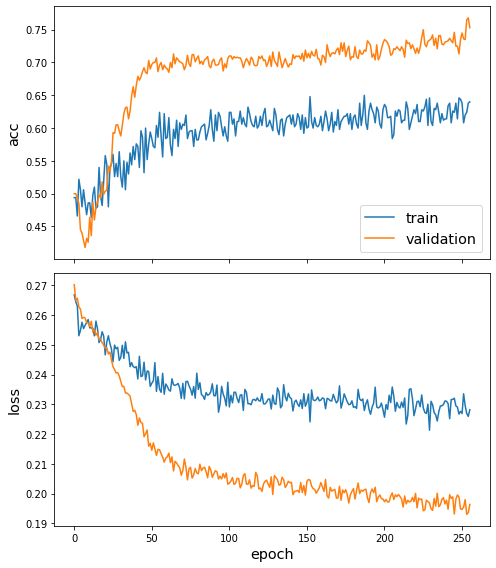

In [7]:
epochs = 256
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

sg.utils.plot_history(history)

## 9.7 Test performance

In [8]:
def evaluate_metrics(title, labels, y_pred):
    print(title)
    print("- Precision =", metrics.precision_score(labels, y_pred))
    print("- Recall    =", metrics.recall_score(labels, y_pred))
    print("- F1-Score  =", metrics.f1_score(labels, y_pred))
    print()

y_pred = np.round(model.predict(train_flow)).flatten()
evaluate_metrics("Performance Training Set:", train_labels, y_pred)

y_pred = np.round(model.predict(test_flow)).flatten()
evaluate_metrics("Performance Test Set:", test_labels, y_pred)

Performance Training Set:
- Precision = 0.5023255813953489
- Recall    = 0.864
- F1-Score  = 0.6352941176470588

Performance Test Set:
- Precision = 0.6802721088435374
- Recall    = 1.0
- F1-Score  = 0.8097165991902835




---
_The end._